# **k-Means Serial**

## **Requirements**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
import time 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 

def standard_encoding(X) :
    standard_encoding_ = OrdinalEncoder().fit_transform(X)
    return  standard_encoding_

## **k-Means class**

In [2]:
class MyKmeans :
    
    def __init__(self, k, X, random_seed, n_iter) :
        
        self.n_iter = n_iter
        n = len(X)
        
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        elif isinstance(X, np.ndarray):
            pass
        
        def initial_clusters() :
           sample_index = resample(range(0, n), n_samples=n, replace=False, random_state=random_seed)
           sample_index = np.array(sample_index)
           size_Cr = round(n/k)
           size_Cr_arr = np.repeat(size_Cr, k-1)
           size_Ck = n - np.sum(size_Cr_arr)
           size_Cr_list = list(size_Cr_arr)
           size_Cr_list.append(size_Ck)
           cluster_labels = np.array([])
           for x in zip(range(0,k), size_Cr_list) :
               cluster_labels = np.concatenate([cluster_labels, np.repeat(x[0], x[1])])
           cluster_labels = np.array([int(x) for x in cluster_labels])
           cluster_labels = cluster_labels[np.argsort(sample_index)] 
           return cluster_labels

        def get_centroid(r, cluster_labels) :
           obs_index = np.arange(n)
           Cr_obs = obs_index[cluster_labels == r]
           X_Cr = X[Cr_obs,:]
           if len(X_Cr) > 0 :
               centroid_Cr = X_Cr.mean(axis=0)
           else :
               centroid_Cr = X.mean(axis=0)
           return centroid_Cr

        def get_centroids(cluster_labels) :
           centroids = [get_centroid(r, cluster_labels) for r in np.arange(k)]
           return centroids

        def intra_cluster_var(r, cluster_labels):
           Cr_obs = np.where(cluster_labels == r)[0] 
           centroids = get_centroids(cluster_labels)
           X_Cr = X[Cr_obs, :]
           dist_Cr_obs = np.linalg.norm(X_Cr - centroids[r], axis=1)
           var_Cr = np.sum(dist_Cr_obs**2)
           return var_Cr

        def WCSS(cluster_labels) :
           intra_cluster_var_arr = np.array([intra_cluster_var(r, cluster_labels) for r in np.arange(k)])
           WCSS_ = np.sum(intra_cluster_var_arr)
           return WCSS_

        def get_new_labels(centroids):
            dist_obs_centroids = np.linalg.norm(X[:, np.newaxis, :] - centroids, axis=2)
            cluster_labels = np.argmin(dist_obs_centroids, axis=1)
            return cluster_labels
       
        self.initial_clusters = initial_clusters
        self.get_centroids = get_centroids
        self.get_new_labels = get_new_labels
        self.WCSS = WCSS
       
       
    def fit(self, ) :
        
        initial_clusters = self.initial_clusters
        get_centroids = self.get_centroids
        get_new_labels = self.get_new_labels
        WCSS = self.WCSS
        
        n_iter = self.n_iter
        WCSS_dict = dict()
        centroids_dict = dict()
        labels_dict = dict()
        b = n_iter - 1

        for iter in range(0, b + 1) :
           
           if iter == 0 :
           
             labels_dict[iter] = initial_clusters()
             centroids_dict[iter] = get_centroids(labels_dict[iter])
             WCSS_dict[iter] = WCSS(labels_dict[iter])

           else :
               
             labels_dict[iter] = get_new_labels(centroids_dict[iter-1]) 
             centroids_dict[iter] = get_centroids(labels_dict[iter])
             WCSS_dict[iter] = WCSS(labels_dict[iter])
        
           # Stop criteria
           if iter >= 2 :
               cond1 = np.isclose(WCSS_dict[iter], WCSS_dict[iter-1], atol=0.00005)
               cond2 = np.isclose(WCSS_dict[iter], WCSS_dict[iter-2], atol=0.00005)
               if cond1 and cond2 :  
                   max_iter = iter + 1
                   break    
               else:
                   max_iter = n_iter
           
        final_clusters_df = pd.DataFrame({'cluster_labels' : labels_dict[max_iter-1]})

        self.WCSS_dict = WCSS_dict
        self.centroids_dict = centroids_dict
        self.labels_dict = labels_dict
        self.max_iter = max_iter
        self.final_clusters_df = final_clusters_df

## **Loading and processing the data**


In [3]:
computers_1000000 = pd.read_csv(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Parallel Programming\Tech Lab 1\Data\computers_1000000.csv')
computers_1000000['cd'] = standard_encoding(computers_1000000[['cd']]) # no=0, yes=1
computers_1000000['laptop'] = standard_encoding(computers_1000000[['laptop']]) # no=0, yes=1
computers_1000000.drop(columns=['id'], inplace=True) # Remove 'id' column
computers_1000000.head()

,price,speed,hd,ram,screen,cores,cd,laptop,trend
0,1250,22,20,10,17,8,0.0,0.0,2
1,3516,38,1,24,17,22,1.0,0.0,5
2,2337,16,20,10,23,12,0.0,0.0,1
3,3247,36,5,52,19,16,0.0,0.0,2
4,3572,36,7,24,23,18,1.0,0.0,4


## **Elbow computation**

In [ ]:
start_time = time.time()
WCSS_Elbow_dict = dict()
for k_ in range(2, 13):
    kmeans = MyKmeans(k=k_, X=computers_1000000, random_seed=123, n_iter=100)
    kmeans.fit()
    WCSS_Elbow_dict[k_] = kmeans.WCSS_dict[kmeans.max_iter-1]
end_time = time.time()

In [8]:
print('Time Elbow computation:', np.round((end_time - start_time)/60, 2), 'mins') 

Time Elbow computation: 12.18 mins


## **Elbow Graph**

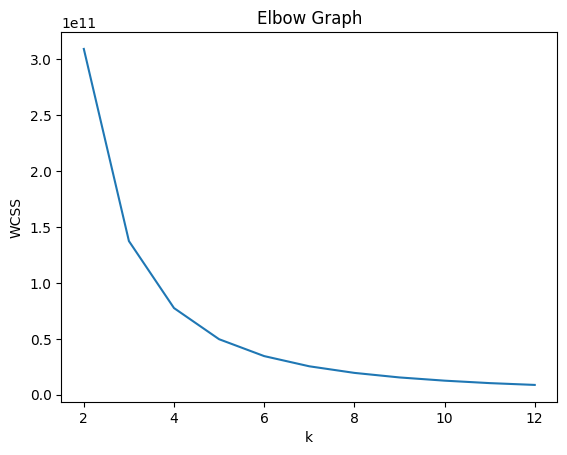

In [9]:
k_values = range(2, 13)
WCSS_Elbow_values = list(WCSS_Elbow_dict.values()) 
sns.lineplot(x=k_values, y=WCSS_Elbow_values)
plt.xlabel("k")  
plt.ylabel("WCSS")  
plt.title("Elbow Graph")  
plt.show()

## **Selection of optimal k**

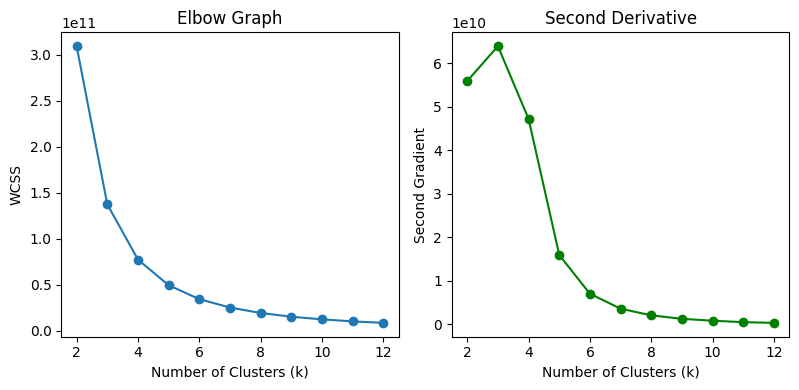

Optimal k: 3


In [10]:
# Calculate the first derivative
first_derivative = np.gradient(WCSS_Elbow_values)
# Calculate the second derivative
second_derivative = np.gradient(first_derivative)
# Plot the Elbow graph and second derivative
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(k_values, WCSS_Elbow_values, marker='o')
plt.title("Elbow Graph")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.subplot(1, 3, 2)
plt.plot(k_values, second_derivative, marker='o', color='green')
plt.title("Second Derivative")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Second Gradient")
plt.tight_layout()
plt.show()
# Computing optimal k
k_optimal = k_values[np.argmax(second_derivative)]

print('Optimal k:' , k_optimal)

## **Training k-means with optimal k** 

In [12]:
start_time = time.time()
kmeans = MyKmeans(k=k_optimal, X=computers_1000000, random_seed=123, n_iter=100)
kmeans.fit()
end_time = time.time()

print('Training k-means with optimal k (for 1.000.000 rows):', np.round(end_time - start_time, 2), 'secs')

Training k-means with optimal k (for 1.000.000 rows): 4.11 secs


## **Computing the cluster with higher average price**


In [14]:
clusters_df = kmeans.final_clusters_df
avg_price_clusters = dict()
for r in range(0, k_optimal) :
    index_Cr = clusters_df.loc[clusters_df['cluster_labels'] == r].index
    avg_price_clusters[r] = computers_1000000.loc[index_Cr, 'price'].mean()
avg_price_clusters_list = list(avg_price_clusters.values())
cluster_higher_price = np.argmax(avg_price_clusters_list)

print('Cluster with higher average price:', cluster_higher_price)
print('Average price:', np.round(avg_price_clusters_list[cluster_higher_price],2))

Cluster with higher average price: 1
Average price: 3709.3


## **Plotting two first PCA dimensions**


In [15]:
X = computers_1000000
clusters_df = kmeans.final_clusters_df
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca_df['cluster_labels'] = clusters_df['cluster_labels']

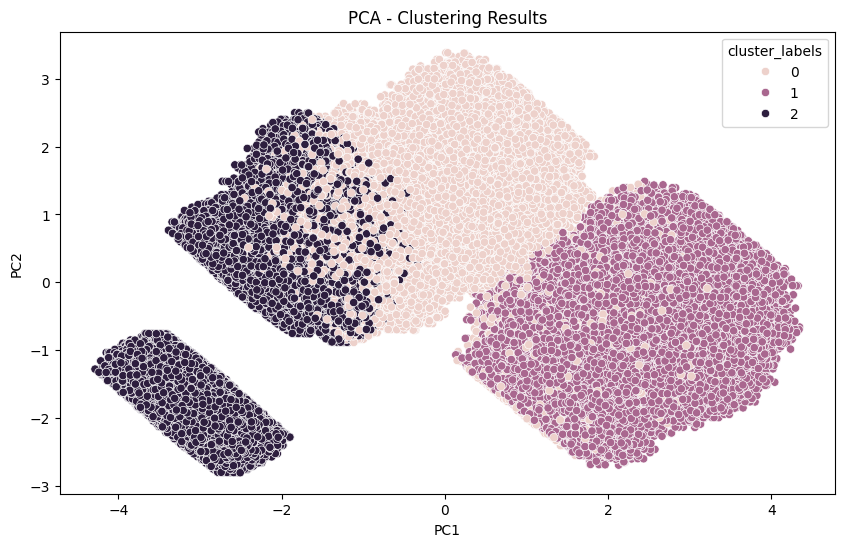

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster_labels', data=X_pca_df)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - Clustering Results')
plt.show()

## **Plotting a HeatMap**


In [27]:
# Normalizing the centroids for plotting the HeatMap
scaler = MinMaxScaler()   
centroids_arr = np.array(kmeans.centroids_dict[kmeans.max_iter-1])
scale_centroids_arr = scaler.fit_transform(centroids_arr)
scale_centroids_df = pd.DataFrame(scale_centroids_arr.T)  
scale_centroids_df.columns = ['centroid_1', 'centroid_2', 'centroid_3']
scale_centroids_df.index = computers_1000000.columns

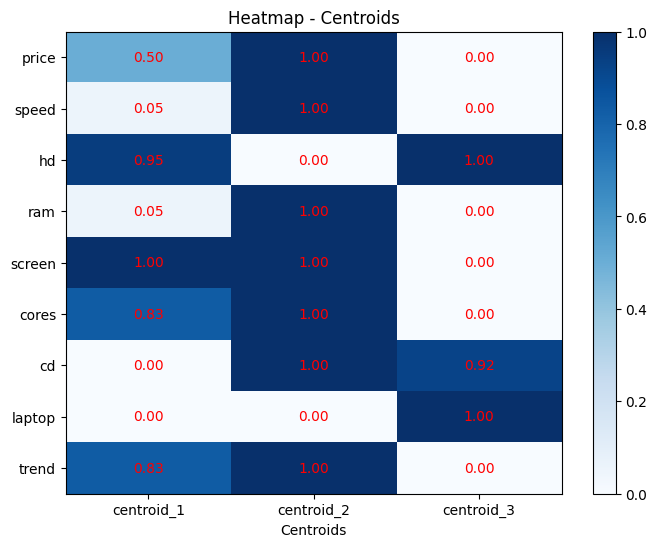

In [38]:
# Plotting the HeatMap
plt.figure(figsize=(8, 6))
cax = plt.imshow(scale_centroids_df, cmap='Blues', aspect='auto')

for j in range(0,scale_centroids_df.shape[1]):
    plt.text(j, 0, f'{scale_centroids_df.iloc[0, j]:.2f}', ha='center', va='center', color='red')

for i in range(1,scale_centroids_df.shape[0]):
    for j in range(0,scale_centroids_df.shape[1]):
        plt.text(j, i, f'{scale_centroids_df.iloc[i, j]:.2f}', ha='center', va='center', color='red')

plt.colorbar(cax) 
plt.title('Heatmap - Centroids')
plt.xlabel('Centroids')
plt.ylabel('Variables')
plt.ylabel('')
plt.xticks(ticks=range(len(scale_centroids_df.columns)), labels=scale_centroids_df.columns)
plt.yticks(ticks=range(len(scale_centroids_df.index)), labels=scale_centroids_df.index)
plt.show()